In [1]:
"""Post-hoc analysis - what we should have done for feature selection.
"""

import sqlite3

import pandas as pd

try:
    database_path = "data/data.db"
    conn = sqlite3.connect(database_path)
    query = open('data/fetch_all.sql', 'r').read()
    df_raw = pd.read_sql_query(query, conn)
except (sqlite3.Error, FileNotFoundError) as e:
    print(f"An error occurred: {e}")
finally:
    if 'conn' in locals():
        conn.close()

# NOTE: Filtering only rows with 'yes' or 'no' in the 'y' column for training
df_full = df_raw.copy()
df_raw.set_index('client_id', inplace=True)

df = df_raw[df_raw['y'].isin(['no', 'yes'])]



In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

def detect_feature_types(df):
    """
    Detect numerical and categorical columns in the dataset
    
    Parameters:
    df (pandas.DataFrame): Input dataset
    
    Returns:
    tuple: Lists of numerical and categorical column names
    """
    # Consider boolean and object types as categorical
    categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns
    # Consider numeric columns with few unique values (less than 10) as categorical
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        if df[col].nunique() < 10:
            categorical_cols = categorical_cols.append(pd.Index([col]))
    
    numerical_cols = df.columns.difference(categorical_cols)
    
    return list(numerical_cols), list(categorical_cols)

def encode_categorical_features(df, categorical_cols, encoding_method='onehot'):
    """
    Encode categorical features using specified method
    
    Parameters:
    df (pandas.DataFrame): Input dataset
    categorical_cols (list): List of categorical column names
    encoding_method (str): 'onehot' or 'label'
    
    Returns:
    tuple: Transformed dataframe and dictionary of encoders
    """
    df_encoded = df.copy()
    encoders = {}
    
    if encoding_method == 'onehot':
        for col in categorical_cols:
            # Create OneHotEncoder for the column
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoded_data = encoder.fit_transform(df[[col]])
            
            # Create column names for encoded features
            encoded_cols = [f"{col}_{val}" for val in encoder.categories_[0]]
            
            # Add encoded columns to dataframe
            encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df.index)
            df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
            
            # Store encoder
            encoders[col] = encoder
            
            # Drop original column
            df_encoded.drop(columns=[col], inplace=True)
            
    elif encoding_method == 'label':
        for col in categorical_cols:
            # Create LabelEncoder for the column
            encoder = LabelEncoder()
            df_encoded[col] = encoder.fit_transform(df[col])
            encoders[col] = encoder
    
    return df_encoded, encoders

def analyze_feature_importance(df, target_column, problem_type='regression', encoding_method='onehot'):
    """
    Analyze feature importance using multiple methods with support for categorical features
    
    Parameters:
    df (pandas.DataFrame): Input dataset
    target_column (str): Name of the target variable column
    problem_type (str): Either 'regression' or 'classification'
    encoding_method (str): 'onehot' or 'label' for categorical features
    
    Returns:
    dict: Dictionary containing importance scores and analysis results
    """
    # Detect feature types
    numerical_cols, categorical_cols = detect_feature_types(df.drop(columns=[target_column]))
    
    # Handle categorical features
    df_processed, encoders = encode_categorical_features(
        df.drop(columns=[target_column]), 
        categorical_cols, 
        encoding_method
    )
    
    # Add target column back
    df_processed[target_column] = df[target_column]
    
    # Scale numerical features
    scaler = StandardScaler()
    df_processed[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])
    
    # Separate features and target
    X = df_processed.drop(columns=[target_column])
    y = df_processed[target_column]
    
    # Initialize results dictionary
    results = {
        'correlation': {},
        'random_forest': {},
        'mutual_info': {},
        'feature_names': list(X.columns),
        'categorical_encoding': {
            'method': encoding_method,
            'categorical_cols': categorical_cols,
            'numerical_cols': numerical_cols,
            'encoders': encoders
        }
    }
    
    # 1. Correlation Analysis
    correlations = df_processed.corr()[target_column].drop(target_column)
    results['correlation'] = correlations.abs().to_dict()
    
    # 2. Random Forest Importance
    if problem_type == 'regression':
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        mi_func = mutual_info_regression
    else:
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        mi_func = mutual_info_classif
    
    rf.fit(X, y)
    results['random_forest'] = dict(zip(X.columns, rf.feature_importances_))
    
    # 3. Mutual Information
    mi_scores = mi_func(X, y, random_state=42)
    results['mutual_info'] = dict(zip(X.columns, mi_scores))
    
    # Calculate aggregate importance score
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Correlation': [results['correlation'][col] for col in X.columns],
        'RandomForest': [results['random_forest'][col] for col in X.columns],
        'MutualInfo': [results['mutual_info'][col] for col in X.columns]
    })
    
    # Add feature type information
    importance_df['FeatureType'] = 'Encoded'
    for col in numerical_cols:
        importance_df.loc[importance_df['Feature'] == col, 'FeatureType'] = 'Numerical'
    
    # Normalize each method's scores
    for col in ['Correlation', 'RandomForest', 'MutualInfo']:
        importance_df[f'{col}_Normalized'] = importance_df[col] / importance_df[col].max()
    
    # Calculate aggregate score (mean of normalized scores)
    importance_df['AggregateScore'] = importance_df[[
        'Correlation_Normalized', 
        'RandomForest_Normalized', 
        'MutualInfo_Normalized'
    ]].mean(axis=1)
    
    # Sort by aggregate score
    importance_df = importance_df.sort_values('AggregateScore', ascending=False)
    results['aggregate_importance'] = importance_df
    
    return results

def plot_feature_importance(results):
    """
    Create visualizations for feature importance analysis with feature type distinction
    
    Parameters:
    results (dict): Output from analyze_feature_importance function
    """
    importance_df = results['aggregate_importance']
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Create bars with different colors for numerical and encoded features
    numerical_mask = importance_df['FeatureType'] == 'Numerical'
    
    plt.bar(
        np.arange(len(importance_df[numerical_mask])),
        importance_df[numerical_mask]['AggregateScore'],
        label='Numerical Features',
        color='royalblue'
    )
    
    plt.bar(
        np.arange(len(importance_df[~numerical_mask])) + len(importance_df[numerical_mask]),
        importance_df[~numerical_mask]['AggregateScore'],
        label='Encoded Categorical Features',
        color='lightcoral'
    )
    
    plt.xticks(
        range(len(importance_df)),
        importance_df['Feature'],
        rotation=45,
        ha='right'
    )
    
    plt.title('Feature Importance (Aggregate Score)')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.legend()
    plt.tight_layout()
    
    return plt

/tmp/ipykernel_94479/3524980222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_encoded'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)


                Feature FeatureType  AggregateScore
3              duration   Numerical        1.000000
49     poutcome_success     Encoded        0.417946
5                 pdays   Numerical        0.274148
0                   age   Numerical        0.201348
6              previous   Numerical        0.197017
50     poutcome_unknown     Encoded        0.190901
45            month_oct     Encoded        0.176914
1               balance   Numerical        0.176303
34      contact_unknown     Encoded        0.140223
28           housing_no     Encoded        0.136946
29          housing_yes     Encoded        0.132486
42            month_mar     Encoded        0.123494
32     contact_cellular     Encoded        0.118250
2                   day   Numerical        0.117112
43            month_may     Encoded        0.109913
24   education_tertiary     Encoded        0.105048
4              campaign   Numerical        0.098262
31             loan_yes     Encoded        0.097050
20      mari

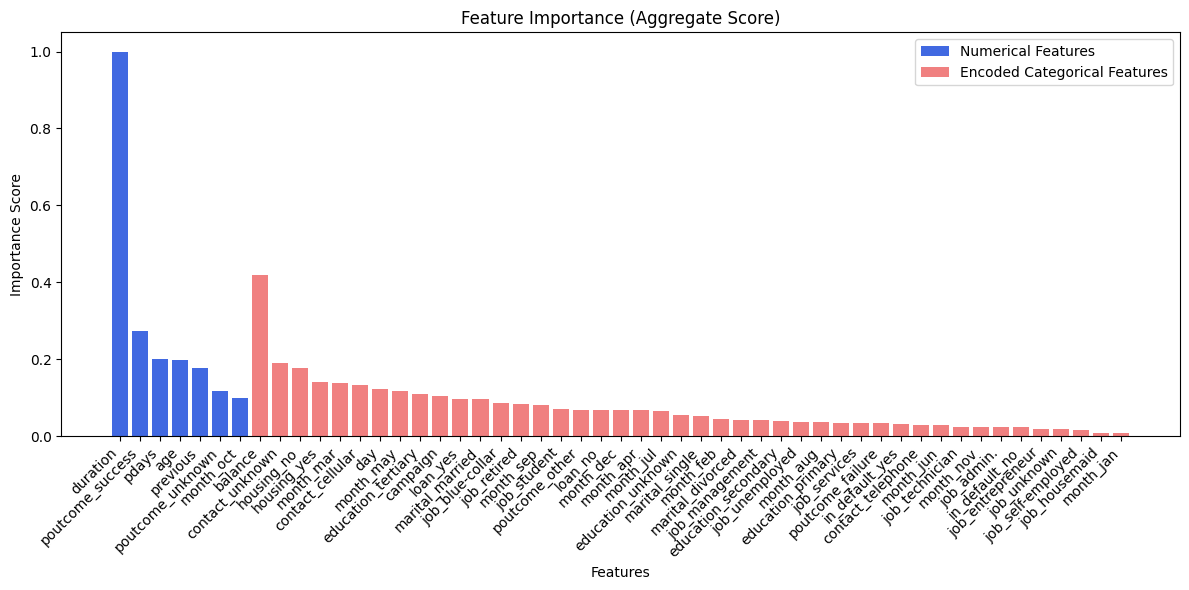

In [3]:
# Encode the target column
df['y_encoded'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df_cut = df.drop(columns=['y', 'account_id', 'campaign_id', 'outcome_id'])

# Run analysis with one-hot encoding
features = analyze_feature_importance(
    df.drop(columns=['y', 'account_id', 'campaign_id', 'outcome_id']),
    'y_encoded',
    problem_type='classification',
    encoding_method='onehot'
)

# View results
print(features['aggregate_importance'][['Feature', 'FeatureType', 'AggregateScore']])

# Create visualization
plot_feature_importance(features)
plt.show()

In [4]:
# Analyze feature correlations - functions
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder

def analyze_feature_correlations(df, target_column=None, threshold=0.7, categorical_encoding='label'):
    """
    Two-step correlation analysis for feature selection and target relationships
    
    Parameters:
    df (pandas.DataFrame): Input dataset
    target_column (str): Name of target column (if None, only feature correlations are analyzed)
    threshold (float): Correlation coefficient threshold for highlighting strong correlations
    categorical_encoding (str): Method for handling categorical variables ('label' or 'skip')
    
    Returns:
    dict: Dictionary containing both feature-feature and feature-target correlation analyses
    """
    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # Separate target if provided
    if target_column:
        target_series = df_processed[target_column]
        features_df = df_processed.drop(columns=[target_column])
    else:
        features_df = df_processed
    
    # Identify numerical and categorical columns
    categorical_cols = features_df.select_dtypes(include=['object', 'category', 'bool']).columns
    numerical_cols = features_df.select_dtypes(include=['int64', 'float64']).columns
    
    # Handle categorical columns
    if categorical_encoding == 'label':
        encoders = {}
        for col in categorical_cols:
            encoder = LabelEncoder()
            features_df[col] = encoder.fit_transform(features_df[col])
            encoders[col] = encoder
    elif categorical_encoding == 'skip':
        features_df = features_df[numerical_cols]
    
    # Calculate feature-feature correlation matrix
    feature_corr_matrix = features_df.corr()
    
    # Get pairs of highly correlated features
    high_correlations = []
    for i in range(len(feature_corr_matrix.columns)):
        for j in range(i+1, len(feature_corr_matrix.columns)):
            corr_value = abs(feature_corr_matrix.iloc[i, j])
            if corr_value >= threshold:
                high_correlations.append({
                    'feature1': feature_corr_matrix.columns[i],
                    'feature2': feature_corr_matrix.columns[j],
                    'correlation': corr_value
                })
    
    # Sort high correlations by absolute value
    high_correlations.sort(key=lambda x: abs(x['correlation']), reverse=True)
    
    # Calculate feature correlation statistics
    feature_stats = {}
    for column in feature_corr_matrix.columns:
        correlations = feature_corr_matrix[column].drop(column)
        feature_stats[column] = {
            'mean_correlation': correlations.abs().mean(),
            'max_correlation': correlations.abs().max(),
            'highly_correlated_count': sum(correlations.abs() >= threshold)
        }
    
    # Create summary DataFrame
    feature_summary = pd.DataFrame.from_dict(feature_stats, orient='index')
    feature_summary = feature_summary.sort_values('mean_correlation', ascending=False)
    
    results = {
        'feature_correlation_matrix': feature_corr_matrix,
        'high_correlations': high_correlations,
        'feature_stats': feature_summary,
        'categorical_columns': list(categorical_cols),
        'numerical_columns': list(numerical_cols)
    }
    
    # Add target correlation analysis if target provided
    if target_column:
        if categorical_encoding == 'label' and target_column in categorical_cols:
            target_series = encoders[target_column].transform(target_series)
        
        # Calculate correlations with target
        target_correlations = features_df.apply(lambda x: stats.pearsonr(x, target_series)[0])
        target_pvalues = features_df.apply(lambda x: stats.pearsonr(x, target_series)[1])
        
        # Add to results
        results['target_correlations'] = {
            'correlations': target_correlations.sort_values(key=abs, ascending=False),
            'pvalues': target_pvalues
        }
    
    return results

def plot_correlation_analysis(results, target_column=None, figsize=(15, 5)):
    """
    Create visualizations for both feature-feature and feature-target correlations
    
    Parameters:
    results (dict): Output from analyze_feature_correlations function
    target_column (str): Name of target column (if provided)
    figsize (tuple): Figure size for the plots
    """
    if target_column:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0]*2/3, figsize[1]))
    
    # Plot 1: Feature Correlation Heatmap
    sns.heatmap(
        results['feature_correlation_matrix'],
        annot=False,  # Remove numbers
        cmap='RdBu',
        center=0,
        vmin=-1,
        vmax=1,
        ax=ax1,
        square=True,
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    ax1.set_title('Feature-Feature Correlation Heatmap')
    
    # Plot 2: Feature Correlation Statistics
    stats_data = results['feature_stats']
    stats_data[['mean_correlation', 'max_correlation']].plot(
        kind='bar',
        ax=ax2
    )
    ax2.set_title('Feature Correlation Statistics')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('Correlation Strength')
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Target Correlations (if target provided)
    if target_column and 'target_correlations' in results:
        target_corrs = results['target_correlations']['correlations']
        target_corrs.plot(
            kind='bar',
            ax=ax3,
            color=['g' if x >= 0 else 'r' for x in target_corrs]
        )
        ax3.set_title(f'Correlations with {target_column}')
        ax3.set_xlabel('Features')
        ax3.set_ylabel('Correlation with Target')
        ax3.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

def get_feature_selection_recommendations(results, target_column=None, max_correlation=0.9):
    """
    Generate feature selection recommendations based on correlation analysis
    
    Parameters:
    results (dict): Output from analyze_feature_correlations function
    target_column (str): Name of target column (if provided)
    max_correlation (float): Maximum allowed correlation between features
    
    Returns:
    dict: Dictionary containing recommendations
    """
    recommendations = {
        'redundant_features': [],
        'important_features': [],
        'selection_suggestions': []
    }
    
    # Find redundant feature pairs
    for pair in results['high_correlations']:
        if pair['correlation'] >= max_correlation:
            feature1, feature2 = pair['feature1'], pair['feature2']
            
            # If we have target correlations, use them to choose between features
            if target_column and 'target_correlations' in results:
                target_corrs = results['target_correlations']['correlations']
                feature1_target_corr = abs(target_corrs[feature1])
                feature2_target_corr = abs(target_corrs[feature2])
                
                keep_feature = feature1 if feature1_target_corr > feature2_target_corr else feature2
                remove_feature = feature2 if feature1_target_corr > feature2_target_corr else feature1
                
                recommendations['selection_suggestions'].append({
                    'features': (feature1, feature2),
                    'correlation': pair['correlation'],
                    'recommendation': f"Keep '{keep_feature}' (target correlation: {max(feature1_target_corr, feature2_target_corr):.3f}) "
                                    f"and consider removing '{remove_feature}' (target correlation: {min(feature1_target_corr, feature2_target_corr):.3f})"
                })
            else:
                recommendations['redundant_features'].append({
                    'features': (feature1, feature2),
                    'correlation': pair['correlation'],
                    'recommendation': f"Consider removing one of these highly correlated features"
                })
    
    # If we have target correlations, identify important features
    if target_column and 'target_correlations' in results:
        target_corrs = results['target_correlations']['correlations']
        pvals = results['target_correlations']['pvalues']
        
        for feature in target_corrs.index:
            if abs(target_corrs[feature]) >= 0.3 and pvals[feature] < 0.05:
                recommendations['important_features'].append({
                    'feature': feature,
                    'target_correlation': target_corrs[feature],
                    'p_value': pvals[feature]
                })
    
    return recommendations


Feature Selection Recommendations:

Most Important Features for Prediction:
duration: correlation = 0.401


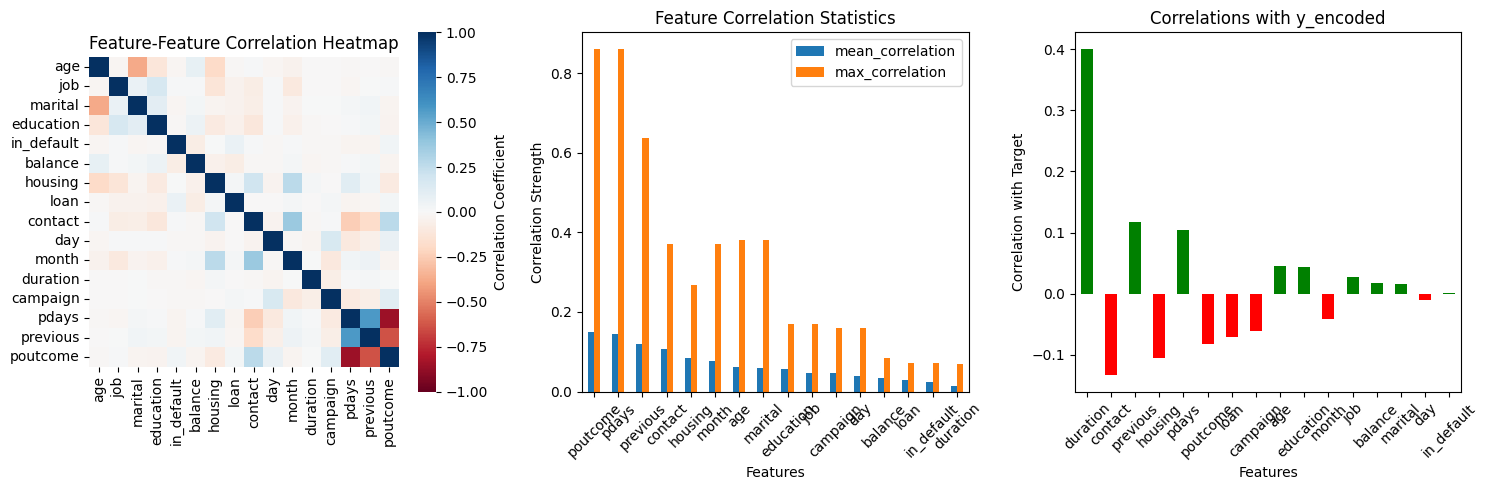

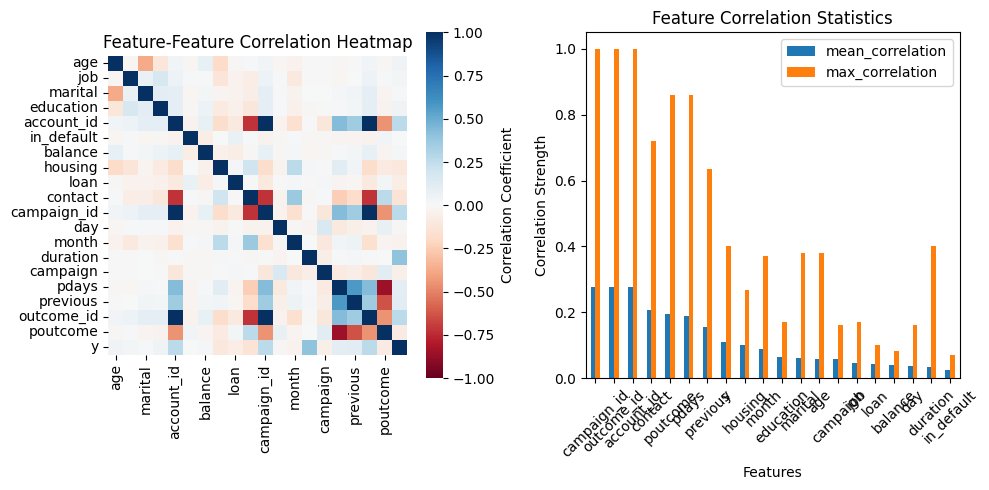

In [5]:
# Run feature correlation analysis
features = analyze_feature_correlations(df_cut, target_column='y_encoded', threshold=0.7)

# Get recommendations
recommendations = get_feature_selection_recommendations(features, target_column='y_encoded')

# Print recommendations
print("\nFeature Selection Recommendations:")
for suggestion in recommendations['selection_suggestions']:
    print(f"\n{suggestion['recommendation']}")

print("\nMost Important Features for Prediction:")
for feature in recommendations['important_features']:
    print(f"{feature['feature']}: correlation = {feature['target_correlation']:.3f}")

# Create visualization
plot_correlation_analysis(features, target_column='y_encoded')
plt.show()

# For feature-only analysis (without target)
feature_results = analyze_feature_correlations(df.drop(columns=['y_encoded']), threshold=0.7)
plot_correlation_analysis(feature_results)
plt.show()